# Introduction

In previous lessons, we've gone from learning the basic components of time series to employing advanced signal transformation techniques. As the culmination of these lessons, we'll now turn toward deep learning as a method for time series forecasting. We'll see how **recurrent neural networks** can automatically learn how to model series components like seasonality and autocorrelation without special preprocessing. In the process, we'll gain exposure to the python library **Keras**, which provides an excellent interface for constructing neural networks. 

# Learning Outcomes
You should walk away from this Python tutorial with:
1. A practical understanding of how to build and train a simple RNN or LSTM for time series forecasting, using keras.
2. Introductory experience in tuning RNN/LSTM parameters.

# Imports

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Python & Library Versions

In [2]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("keras", keras.__version__) )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

('2.7.15 |Anaconda, Inc.| (default, May  1 2018, 18:37:05) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]', '\n')
library    version
------------------
matplotlib  2.2.2
numpy       1.14.3
pandas      0.23.0
keras       2.2.0


# Section 1: Simple RNN

In this section, we will build a recurrent neural network and train it to forecast a single time series. We'll use a dataset provided by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) that measures hourly air quality in Chinese cities/city districts<sup>1</sup>.

1. Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), PM2.5 data reliability, consistency, and air quality assessment in five Chinese cities, J. Geophys. Res. Atmos., 121, 10220â€“10236

#### Setting Up The Data

We'll start by working with Beijing data, and filter the dataset down to records from 2015. 

In [3]:
df_Beijing = pd.read_csv('../Data/FiveCitiesPM/Beijing.csv')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


We are interested in attempting to forecast the 'PM' series, which are measurements of air pollution for several different districts.  Note that there are occasional missing values in these series, which we can fill with simple linear interpolation. To start, we'll focus on the "PM_Dongsi" series and interpolate the missing values. 

In [4]:
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

As usual, it's a good idea for us to generate a run-sequence plot before modeling the data. This way we can get a feel for what we're working with. We'll go ahead and define two utility functions that let us extract and plot the last $n$ days of data (remember that this is an hourly time series, so each day has 24 time steps).   

In [5]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(24*n_days):] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
       
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

What do the last 6 weeks of data look like?

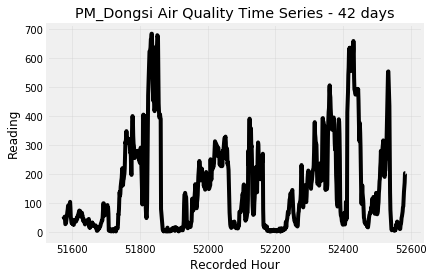

In [8]:
plot_n_last_days(df_Beijing, 'PM_Dongsi', 42)

**Review Question**: what components that you've learned in previous lessons appear to be present in this time series? 

**Answer**: There appears to be a periodic component as well as autocorrelation structure.

#### Example 1: Train a simple RNN to forecast the PM_Dongsi time series

Before we can train a neural network with keras, we need to process the data into a format that the library accepts. In particular, for keras RNNs and LSTMs, training samples should be stored in a 3D numpy array of shape **(n_samples, time_steps, n_features)**. Since we'll be using only the series' history to predict its future, we'll only have 1 feature. Also, for the next-step prediction that we'll do in this notebook, target values can be stored in a simple list.

To this end, we define utility functions that allow us to extract the formatted data. The **get_train_test_data** function gives us the flexibility to define the length of the extracted training and test sequences and the number of time steps to use for prediction -- we'll run simple tests of our models by holding out the end of the extracted sequence and generating predictions to compare against the ground truth.

Since our model will perform better with multiple training samples, we draw many slices from the entire training sequence, starting at different points in time. The gap between starting points of these slices is controlled by the **sample_gap** parameter.

In [7]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values

    train = forecast_series[:-test_hours]
    test = forecast_series[-test_hours:]

    train_X, train_y = [], []

    for i in range(0, train.shape[0]-input_hours, sample_gap):
        train_X.append(train[i:i+input_hours])
        train_y.append(train[i+input_hours])

    train_X = get_keras_format_series(train_X)    
    
    test_X_init = test[:input_hours]
    test_y = test[input_hours:]
    
    return train_X, test_X_init, train_y, test_y

With the **get_train_test_data** utility function in hand, we're all set to extract keras-friendly arrays and start training simple RNN models. We run this function in the cell below. We use the last 56 days of the PM_Dongsi series, and will train a model that takes in 12 time steps in order to predict the next time step. We use the last day of data for visually testing the model.    

In [9]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))

Below we see that by taking multiple time slices, we get 436 training samples of 12 time steps each. 

In [ ]:
print('Training shape: {}'.format(train_X.shape))

And now we're ready to train! Since we'd like to repeatedly adjust our model's hyperparameters to see what works best, we'll write a reusable function for training a simple RNN model using keras. Take some time to understand what the keras syntax accomplishes at each step and how it relates to what we've learned about RNNs so far.  

In [ ]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

Great, now let's use this function to fit a very simple baseline model.

In [ ]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

Not bad so far. But we need to work a bit harder to actually extract multi-step predictions from this model, as it was trained to predict only one future time step. For multi-step forecasting, we'll iteratively generate one prediction, append it to the end of the input sequence (and shift that sequence forward by one step), then feed the new sequence back to the model. We stop once we've generated all the time step predictions we need. 

This prediction method and a utility function for plotting its output against the ground truth are defined below. Take some time time to familiarize yourself with the prediction method.    

In [ ]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:]
        X_init[:,-1,:] = pred
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) 
    
    start_range = range(1, input_hours+1)
    predict_range = range(input_hours, test_hours) 
    
    plt.plot(start_range, test_X_init)
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

Ok, we've finally arrived at the time to see how our baseline model does. We can simply run the **predict_and_plot** function on the extracted test data as below, and inspect the resulting plot. 

In [ ]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

It looks like our model is badly underfit and essentially just making constant predictions. That's ok, it was a very simple baseline and trained very quickly. 

We can improve by making the model more expressive, **increasing cell_units**. We can also pass over the training data many more times, **increasing epochs**, giving the model more opportunity to learn the patterns in the data. We'll try that below, it takes a longer time now since our training is more extensive.

Note that there is a significant amount of randomness in neural network training - we may need to retrain the model a few times in order to get
results that we're happy with.

In [ ]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

We can definitely get better results than before. Note that the model has the capacity to forecast an upward trend based on the trough pattern that occured recently (the input sequence). 

Once we've created a model object, we can also get information about its structure and number of parameters by using the **summary** function. This is a useful way to measure the complexity of the model and get a feel for how long it may take to train. 

In [ ]:
model.summary()

Note that even for this relatively simple model, we already have almost a thousand parameters to train. A larger number of cell units would increase the number of parameters - this is why the training process can become so time consuming.    

#### Exercise 1: Train a simple RNN to forecast the PM_Nongzhanguan time series

We can reuse all of the functions we've defined so far in order to train models on different time series. In this exercise, you'll train your own model to forecast the "PM_Nongzhanguan" series from the Beijing dataframe.

**Step 1**: Interpolate the missing values in the "PM_Nongzhanguan" series and plot the last 42 days of the series to get a feel for the data. 
* We'll do this step together to get started

In [ ]:
df_Beijing['PM_Nongzhanguan'] = df_Beijing['PM_Nongzhanguan'].interpolate()
df_Beijing['PM_Nongzhanguan'].head(10)

In [ ]:
plot_n_last_days(df_Beijing, 'PM_Nongzhanguan', 42)

**Step 2**: Extract the train and test data for the "PM_Nongzhanguan" series using the function **get_train_test_data**. Use the following set of parameters:  

* **series_days** : 56
* **input_hours** : 12
* **test_hours** : 48

For reference, below is how we called the function earlier on. You can also pull up the function's documentation to review the various arguments. 

```
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))
```

In [ ]:
# Exercise 1 Step 2


**Step 3**: Using the extracted train data to fit a simple RNN, and use the test data to generate and plot predictions.

* Start with a simple baseline -- few cell units and epochs. From here, try to make the model more expressive by increasing units and epochs until you're satisfied with the model's predictions. 

* Be careful not to set units and/or epochs *too* high. The model may become very slow to train and also start to badly overfit the training data with the extra complexity you've added.

For reference, here's example code that you can adapt:
```
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')
```

In [ ]:
# Exercise 1 Step 3


Again, we're able to do a decent job forecasting the continuation of an uptrend. We'll likely face more difficulty if we try to predict further into the future, especially with a simple RNN. 

# Section 2: LSTM

In this section, we'll build on our previous work by introducing LSTM models as an enhancement to the RNNs we've trained so far. Our first step will be to write a new function for fitting an LSTM with keras - notice that it's almost the same as our simple RNN function, with **LSTM** substitued for **SimpleRNN** (this is a nice display of how flexible keras is). 

Take some time to review the logic of the function while we go ahead and run the example cell below (it will take a while). 

In [ ]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

#### Example 2: Train a LSTM to forecast the PM_Nongzhanguan time series

With our new LSTM training function and all of our previously defined utility functions, adapting our code for LSTM forecasting will be fairly simple. We can extract the data as we did before, call the **fit_LSTM** function to build a model, and run the same *predict_and_plot* code.

Remember that one of the key benefits of LSTMs over simple RNNs is that they are better equipped to handle long input sequences and long-term dependencies. To see this evidence of this, we'll set *input_hours* to 12 and *test_hours* to 96 and see how our model predictions turn out with LSTM.  

In [ ]:
series_days = 50 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000)

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

In our prediction plot we can start to see how LSTMs can be more expressive than simple RNNs - instead of just extrapolating a simple trend like our previous RNN models did, this LSTM model can effectively anticipate inflection points.

You should also notice that our model starts to struggle toward the end of the predicted sequence, becoming more conservative in its predictions. To improve the quality of forecasts over many time steps, we'd likely need to use more data and more sophisticated LSTM model structures that are beyond the scope of this lesson.

Take a look at the model summary and compare it with the summary for our simple RNN from example 1. You can see that there are many more trainable parameters for the LSTM, which explains why it took a much longer time for us to train this model.

In [ ]:
model.summary()

#### Exercise 2: Train a LSTM to forecast the PM_Dongsi time series

Adapt the code above from Example 2 in order to build an LSTM that forecasts the "PM_Dongsi" series. Use the following set of parameters:  

* **series_days** : 50
* **input_hours** : 12
* **test_hours** : 48

Remember our simple parameter tuning strategy, and that LSTMs take significantly longer to train than simple RNNs.

* Start with a simple baseline -- few cell units and epochs. From here, try to make the model more expressive by increasing units and epochs until you're satisfied with the model's predictions. 

* Be careful not to set units and/or epochs *too* high. The model may become very slow to train and also start to badly overfit the training data with the extra complexity you've added.

In [ ]:
# Exercise 2


It turns out this segment of the series was a less interesting one to forecast than what we saw in example 2, but it can still demonstrate LSTMs' ability to learn patterns. 

In this case, the LSTM model anticipates a steady upward trend, but fails to catch the more dramatic climb toward the end of the series. Like in the example, the more steps we take into the future, the more difficult it becomes to predict well. 

#### Further Exploration

The simple models we've worked with are only the tip of the iceberg for deep learning. We've been time-limited for this exercise, and typical deep learning models involve much longer training times than what we're able to do in this notebook. 

Here are several suggestions for how you could explore these ideas further, leveraging the code we've implemented today:

* Try using longer chunks of the series we've looked at in this notebook for modeling (set series_days larger than 56), or modeling other series in the dataset.
* When training with more data, try increasing cell_units and running more training epochs.  
* Try using longer input sequences with LSTM, and predicting a wider range of test hours.

# Summary

In this lesson you should have learned:

1. How recurrent neural networks can be applied to sequence forecasting problems
2. How simple RNNs and LSTMs can be built and trained using the python library keras
3. The importance of tuning network parameters, and an introductory strategy for doing so

Congratulations! This concludes the lesson.